# TrustECG: Explainable Multi-Label ECG Classification

**Author**: [Your Name]  
**Date**: February 2026

---

## Problem Statement

Electrocardiograms (ECGs) are the most common diagnostic tool for cardiac conditions. However, interpreting 12-lead ECGs requires expertise and is time-consuming. In this project, we build a **deep learning model** that can:

1. Automatically classify ECG recordings into **5 cardiac conditions** (multi-label)
2. Provide **explainable predictions** using attention mechanisms
3. Show **which parts of the ECG signal** and **which leads** are most important for the diagnosis

### Target Classes

- **NORM** - Normal ECG
- **MI** - Myocardial Infarction (heart attack)
- **STTC** - ST/T Changes
- **CD** - Conduction Disturbance
- **HYP** - Hypertrophy

### Why Multi-Label?

A patient can have multiple conditions simultaneously (e.g., MI + STTC). So instead of single-class classification, we use **sigmoid activation** with **binary cross-entropy loss** to predict probability for each condition independently.


## 1. Setup and Imports


In [29]:
# Standard libraries
import numpy as np
import pandas as pd
from pathlib import Path
import ast
import warnings

warnings.filterwarnings("ignore")

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# ECG signal processing
import wfdb
from scipy import signal as scipy_signal
from scipy.stats import skew, kurtosis

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Metrics
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Progress bar
from tqdm.auto import tqdm

# Set style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 2050


In [30]:
# Configuration - keeping everything in one place makes it easier to experiment
CONFIG = {
    "data_path": Path("../dataset"),
    "sampling_rate": 100,  # Using 100Hz version (faster to train, good enough accuracy)
    "sequence_length": 1000,  # 10 seconds * 100Hz
    "num_leads": 12,
    # Classes
    "class_names": ["NORM", "MI", "STTC", "CD", "HYP"],
    "num_classes": 5,
    # Training
    "batch_size": 64,
    "epochs": 30,
    "learning_rate": 1e-3,
    "weight_decay": 0.01,
    # Model
    "encoder_channels": [32, 64, 128],
    "dropout": 0.3,
    # Seed for reproducibility
    "seed": 42,
}

# Lead names for visualization
LEAD_NAMES = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

# Colors for classes
CLASS_COLORS = {
    "NORM": "#2ecc71",
    "MI": "#e74c3c",
    "STTC": "#f39c12",
    "CD": "#9b59b6",
    "HYP": "#3498db",
}

# Set seeds
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG["seed"])

print("Configuration loaded!")

Configuration loaded!


## 2. Dataset: PTB-XL

We're using the **PTB-XL dataset** from PhysioNet - one of the largest publicly available clinical ECG datasets.

- **21,801** 12-lead ECG recordings
- **18,869** unique patients
- **10 seconds** duration each
- Pre-defined stratification folds for reproducible train/val/test splits


In [31]:
# --- Load PTB-XL Metadata ---
# Inspect dataset demographics: total records, patient count, age/sex distribution

df = pd.read_csv(CONFIG["data_path"] / "ptbxl_database.csv", index_col="ecg_id")

print(f"Total ECG recordings: {len(df):,}")
print(f"Unique patients: {df['patient_id'].nunique():,}")
print(f"\nPatient demographics:")
print(
    f"  Age: {df['age'].mean():.1f} ± {df['age'].std():.1f} years (range: {df['age'].min():.0f}-{df['age'].max():.0f})"
)
print(f"  Male: {(df['sex']==0).sum():,} ({(df['sex']==0).mean()*100:.1f}%)")
print(f"  Female: {(df['sex']==1).sum():,} ({(df['sex']==1).mean()*100:.1f}%)")

df.head()

Total ECG recordings: 21,799
Unique patients: 18,869

Patient demographics:
  Age: 62.8 ± 32.3 years (range: 2-300)
  Male: 11,354 (52.1%)
  Female: 10,445 (47.9%)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [32]:
# --- Parse SCP Codes into 5 Superclass Labels ---
# Map PTB-XL diagnostic codes to NORM, MI, STTC, CD, HYP (likelihood ≥ 50%)

scp_df = pd.read_csv(CONFIG["data_path"] / "scp_statements.csv", index_col=0)


def parse_scp_codes(scp_codes_str, scp_mapping):
    """Convert SCP diagnostic codes to 5-class multi-label vector."""
    labels = np.zeros(5, dtype=np.float32)
    try:
        scp_dict = ast.literal_eval(scp_codes_str)
    except:
        return labels

    for code, likelihood in scp_dict.items():
        if code in scp_mapping.index and likelihood >= 50:
            diagnostic_class = scp_mapping.loc[code, "diagnostic_class"]
            if pd.notna(diagnostic_class) and diagnostic_class in CONFIG["class_names"]:
                class_idx = CONFIG["class_names"].index(diagnostic_class)
                labels[class_idx] = 1.0
    return labels


df["labels"] = df["scp_codes"].apply(lambda x: parse_scp_codes(x, scp_df))

for i, cls in enumerate(CONFIG["class_names"]):
    df[cls] = df["labels"].apply(lambda x: x[i])

print("Labels created!")

Labels created!


### 2.1 Class Distribution Analysis

Let's see how balanced our classes are. Class imbalance is common in medical datasets and we'll need to handle it.


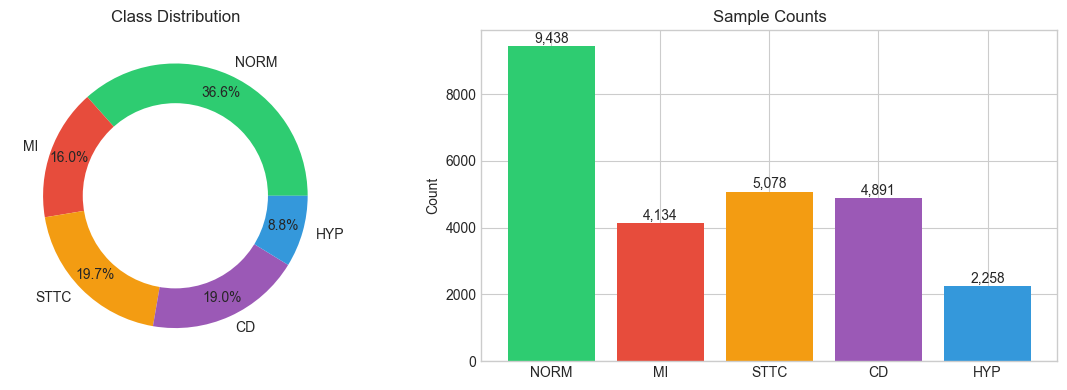


Class counts and percentages:
  NORM: 9,438 (43.3%)
  MI: 4,134 (19.0%)
  STTC: 5,078 (23.3%)
  CD: 4,891 (22.4%)
  HYP: 2,258 (10.4%)


In [33]:
# --- Class Distribution Analysis ---
# Visualize label frequencies to understand class imbalance in the dataset

from pathlib import Path

FIGURES_DIR = Path("../figures")
FIGURES_DIR.mkdir(exist_ok=True)

class_counts = {cls: df[cls].sum() for cls in CONFIG["class_names"]}

# Matplotlib figure for saving
fig_save, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
axes[0].pie(
    list(class_counts.values()),
    labels=list(class_counts.keys()),
    colors=[CLASS_COLORS[c] for c in class_counts.keys()],
    autopct="%1.1f%%",
    pctdistance=0.85,
)
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
axes[0].add_artist(centre_circle)
axes[0].set_title("Class Distribution")

# Bar chart
bars = axes[1].bar(
    list(class_counts.keys()),
    list(class_counts.values()),
    color=[CLASS_COLORS[c] for c in class_counts.keys()],
)
for bar, val in zip(bars, class_counts.values()):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 100,
        f"{int(val):,}",
        ha="center",
        fontsize=10,
    )
axes[1].set_title("Sample Counts")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "01_class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nClass counts and percentages:")
for cls, count in class_counts.items():
    print(f"  {cls}: {int(count):,} ({count/len(df)*100:.1f}%)")

**Observations:**

1. **Class Imbalance**: The dataset shows significant class imbalance:
   - NORM (43.3%) is the most common - nearly half of all recordings are from healthy patients
   - HYP (10.4%) is the rarest - hypertrophy is less common in clinical settings
   - MI, STTC, CD are relatively balanced (19-23%)

2. **Clinical Implications**: This distribution reflects real-world prevalence where normal ECGs are common, and we'll need to handle class imbalance during training (using weighted loss or proper metrics like AUROC).

3. **Multi-Label Nature**: Total percentages exceed 100% because patients can have multiple conditions simultaneously.


Multi-label distribution:
  No condition: 1,426
  Single condition: 15,983
  Two conditions: 3,484
  Three+ conditions: 906


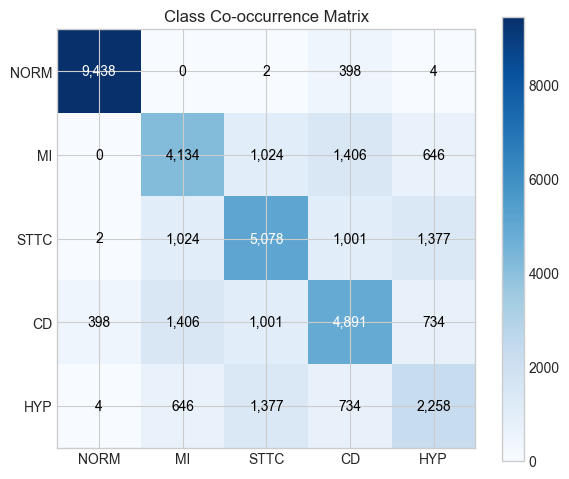

In [34]:
# --- Multi-Label Co-occurrence Analysis ---
# Examine how often multiple cardiac conditions appear together

labels_matrix = np.stack(df["labels"].values)
label_counts = labels_matrix.sum(axis=1)

print("Multi-label distribution:")
print(f"  No condition: {(label_counts == 0).sum():,}")
print(f"  Single condition: {(label_counts == 1).sum():,}")
print(f"  Two conditions: {(label_counts == 2).sum():,}")
print(f"  Three+ conditions: {(label_counts >= 3).sum():,}")

# Co-occurrence heatmap
co_occurrence = np.zeros((5, 5), dtype=int)
for i in range(5):
    for j in range(5):
        co_occurrence[i, j] = np.sum((labels_matrix[:, i] == 1) & (labels_matrix[:, j] == 1))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(co_occurrence, cmap="Blues")
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(CONFIG["class_names"])
ax.set_yticklabels(CONFIG["class_names"])
ax.set_title("Class Co-occurrence Matrix")

for i in range(5):
    for j in range(5):
        ax.text(
            j,
            i,
            f"{co_occurrence[i, j]:,}",
            ha="center",
            va="center",
            color="white" if co_occurrence[i, j] > co_occurrence.max() / 2 else "black",
            fontsize=10,
        )

plt.colorbar(im)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "02_co_occurrence.png", dpi=150, bbox_inches="tight")
plt.show()

**Observations:**

1. **Multi-Label Distribution**:
   - **Single condition** (15,983 = 73%): Most patients have only one diagnosis
   - **No condition** (1,426 = 6.5%): Some ECGs don't map to any of our 5 superclasses
   - **Two conditions** (3,484 = 16%): Common combinations exist
   - **Three+ conditions** (906 = 4%): Complex multi-morbidity is less common

2. **Co-occurrence Patterns**:
   - **STTC + MI** shows strong co-occurrence (makes sense: MI often causes ST changes)
   - **NORM** rarely co-occurs with other conditions (as expected)
   - **CD + STTC** has moderate co-occurrence (conduction issues can affect ST/T waves)

3. **Model Design Implication**: Multi-label architecture with sigmoid outputs is appropriate since conditions can co-exist.


### 2.2 Loading ECG Signals

The signals are stored in WFDB format (.dat + .hea files). Let's load a few samples and visualize them.


In [35]:
# --- Load ECG Signal from WFDB Format ---
# Read raw 12-lead signals stored as .dat/.hea file pairs


def load_ecg_signal(ecg_id, sampling_rate=100):
    """Load a single ECG signal by its ID. Returns shape (1000, 12)."""
    folder = (ecg_id - 1) // 1000 * 1000

    if sampling_rate == 100:
        path = CONFIG["data_path"] / f"records100/{folder:05d}/{ecg_id:05d}_lr"
    else:
        path = CONFIG["data_path"] / f"records500/{folder:05d}/{ecg_id:05d}_hr"

    record = wfdb.rdrecord(str(path))
    return record.p_signal  # Shape: (1000, 12)


sample_id = 1
sample_ecg = load_ecg_signal(sample_id)
print(f"ECG shape: {sample_ecg.shape}")
print(f"Duration: {sample_ecg.shape[0] / CONFIG['sampling_rate']} seconds")
print(f"Leads: {sample_ecg.shape[1]}")

ECG shape: (1000, 12)
Duration: 10.0 seconds
Leads: 12


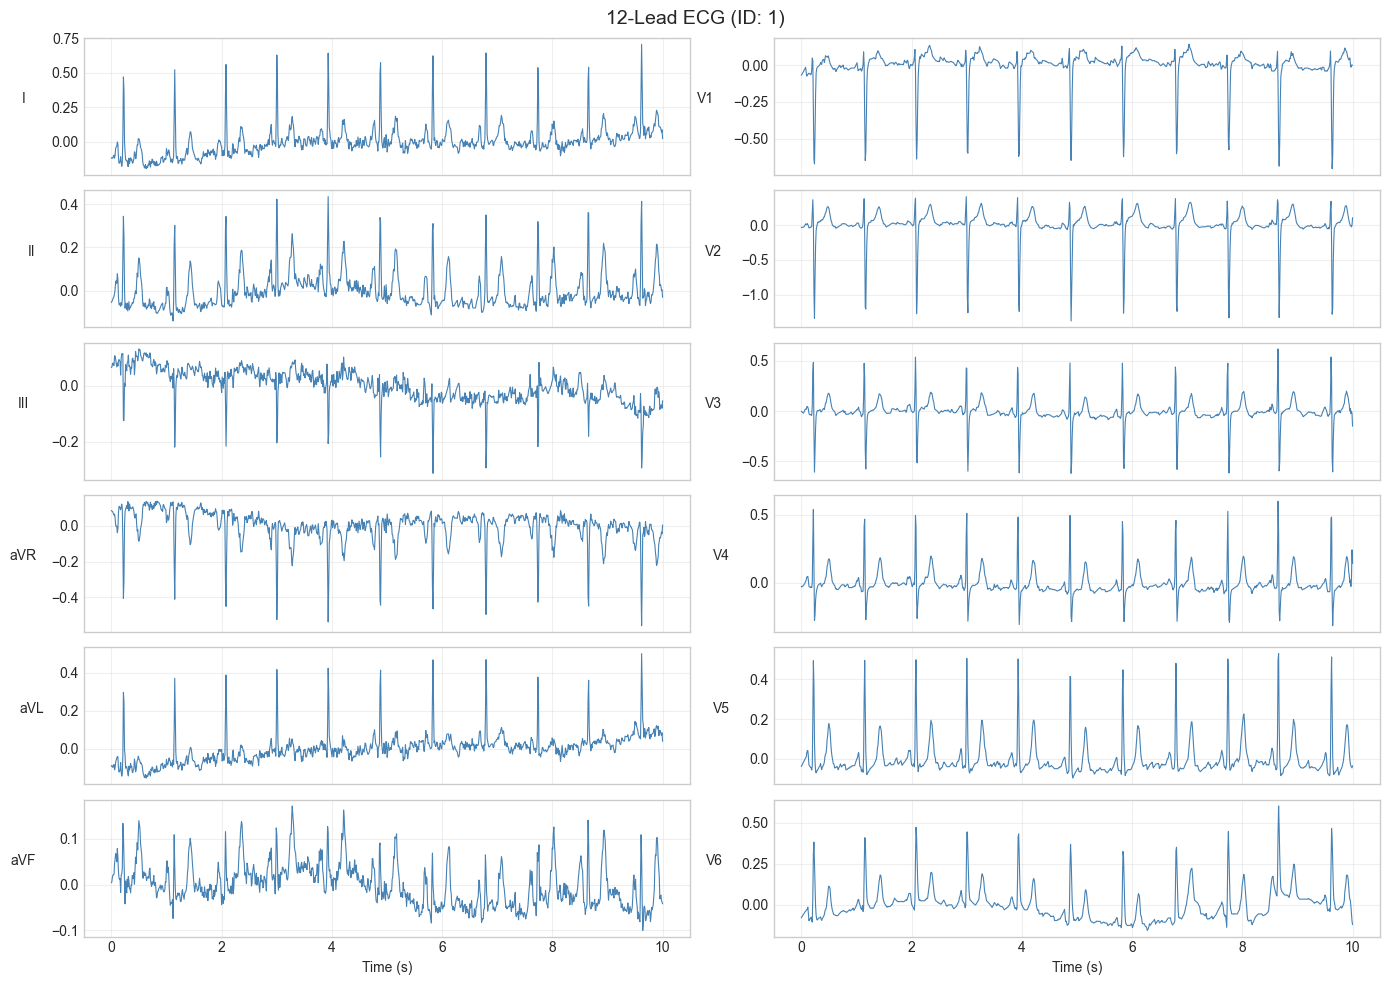


Patient 1 labels:
  ✓ NORM


In [36]:
# --- 12-Lead ECG Visualization ---
# Display all 12 leads for a sample ECG recording


def plot_12_lead_ecg(signal, title="12-Lead ECG", ecg_id=None):
    """Plot all 12 leads of an ECG in a 6x2 grid."""
    fig, axes = plt.subplots(6, 2, figsize=(14, 10), sharex=True)
    t = np.linspace(0, 10, signal.shape[0])

    for i, lead in enumerate(LEAD_NAMES):
        row = i % 6
        col = i // 6
        axes[row, col].plot(t, signal[:, i], color="steelblue", linewidth=0.8)
        axes[row, col].set_ylabel(lead, rotation=0, labelpad=20, fontsize=10)
        axes[row, col].grid(True, alpha=0.3)

    axes[5, 0].set_xlabel("Time (s)")
    axes[5, 1].set_xlabel("Time (s)")
    title_text = f"{title} (ID: {ecg_id})" if ecg_id else title
    fig.suptitle(title_text, fontsize=14)
    plt.tight_layout()
    return fig


fig = plot_12_lead_ecg(sample_ecg, ecg_id=sample_id)
plt.savefig(FIGURES_DIR / "03_sample_12lead_ecg.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nPatient {sample_id} labels:")
for cls in CONFIG["class_names"]:
    if df.loc[sample_id, cls] == 1:
        print(f"  ✓ {cls}")

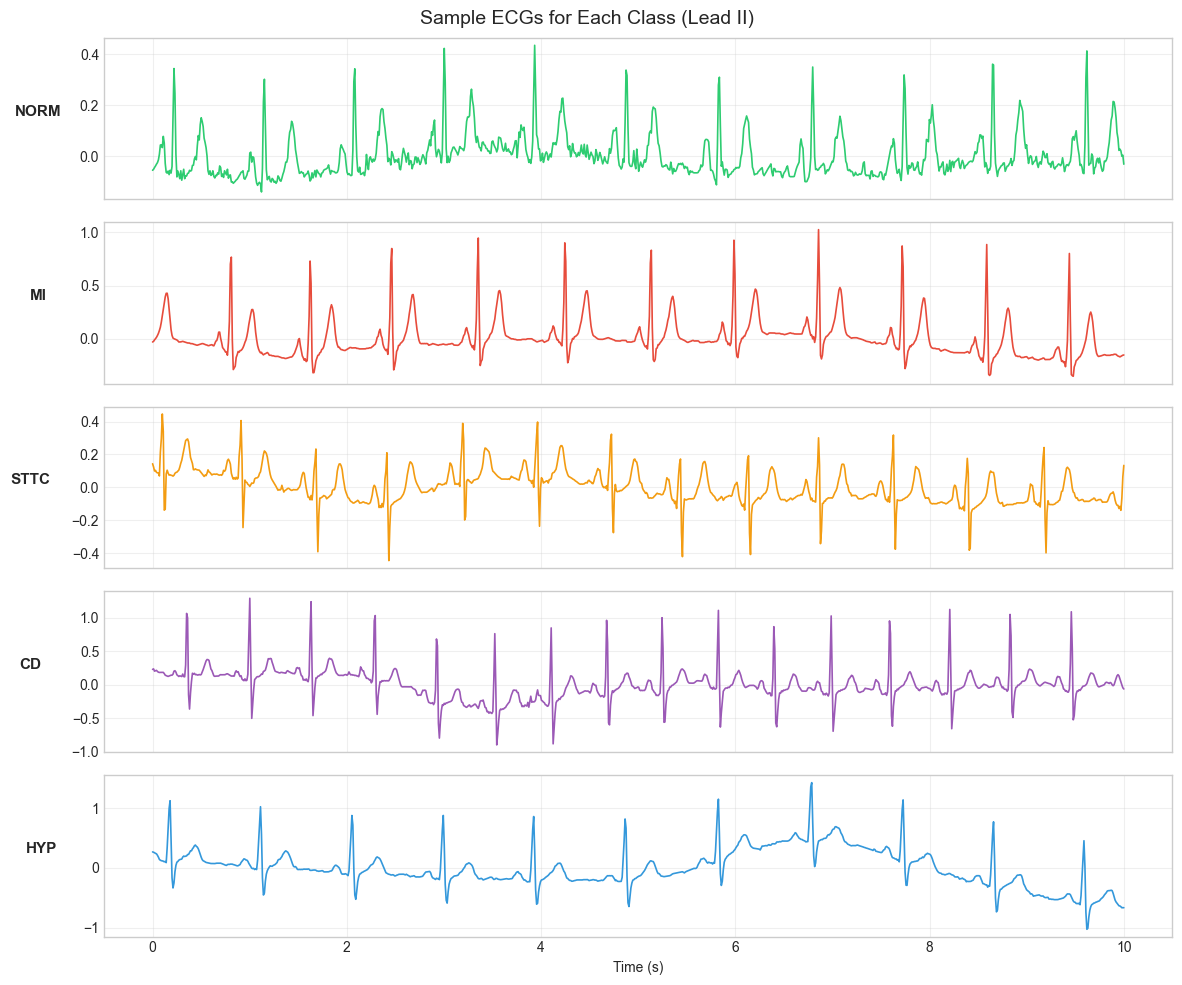

In [37]:
# --- Per-Class ECG Examples ---
# Show Lead II waveform for one representative sample from each diagnostic class

fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
t = np.linspace(0, 10, 1000)

for i, cls in enumerate(CONFIG["class_names"]):
    mask = df[cls] == 1
    if mask.sum() > 0:
        ecg_id = df[mask].index[0]
        signal = load_ecg_signal(ecg_id)
        axes[i].plot(t, signal[:, 1], color=CLASS_COLORS[cls], linewidth=1.2)
        axes[i].set_ylabel(cls, rotation=0, labelpad=30, fontsize=11, fontweight="bold")
        axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Sample ECGs for Each Class (Lead II)", fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "04_class_examples.png", dpi=150, bbox_inches="tight")
plt.show()

### 2.3 Train/Validation/Test Split

PTB-XL comes with pre-defined stratification folds (`strat_fold` column). This ensures:

1. No patient appears in both train and test sets
2. Class distribution is similar across splits
3. Results are reproducible across different studies

We'll use:

- **Folds 1-8**: Training (80%)
- **Fold 9**: Validation (10%)
- **Fold 10**: Test (10%)


In [38]:
# --- Train/Val/Test Split by Stratification Fold ---
# PTB-XL provides pre-defined folds to ensure no patient leakage across splits

train_df = df[df["strat_fold"].isin([1, 2, 3, 4, 5, 6, 7, 8])]
val_df = df[df["strat_fold"] == 9]
test_df = df[df["strat_fold"] == 10]

print(f"Dataset splits:")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")

print("\nClass distribution per split:")
for cls in CONFIG["class_names"]:
    train_pct = train_df[cls].mean() * 100
    val_pct = val_df[cls].mean() * 100
    test_pct = test_df[cls].mean() * 100
    print(f"  {cls}: Train={train_pct:.1f}%, Val={val_pct:.1f}%, Test={test_pct:.1f}%")

Dataset splits:
  Train: 17,418 (79.9%)
  Val:   2,183 (10.0%)
  Test:  2,198 (10.1%)

Class distribution per split:
  NORM: Train=43.3%, Val=43.2%, Test=43.4%
  MI: Train=19.0%, Val=18.9%, Test=18.9%
  STTC: Train=23.3%, Val=23.4%, Test=23.0%
  CD: Train=22.4%, Val=22.7%, Test=22.6%
  HYP: Train=10.4%, Val=9.9%, Test=10.1%


## 3. Data Preprocessing and PyTorch Dataset

### Preprocessing Steps:

1. **Bandpass filter** (0.5-40 Hz): Removes baseline wander and high-frequency noise
2. **Z-score normalization**: Per-sample standardization

Why these values?

- 0.5 Hz: Removes slow baseline drift from breathing/movement
- 40 Hz: ECG clinical information is mostly below 40Hz, higher frequencies are typically noise


In [39]:
from scipy.signal import butter, filtfilt
from torch.utils.data import Dataset, DataLoader

# Define shortcuts for convenience
DATASET_DIR = CONFIG["data_path"]
TARGET_COLS = CONFIG["class_names"]


class ECGPreprocessor:
    """Preprocesses raw ECG signals with bandpass filter and normalization."""

    def __init__(self, lowcut=0.5, highcut=40.0, fs=100, normalize=True):
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.normalize = normalize

    def bandpass_filter(self, signal):
        """Apply Butterworth bandpass filter."""
        nyquist = 0.5 * self.fs
        low = self.lowcut / nyquist
        high = self.highcut / nyquist
        b, a = butter(N=2, Wn=[low, high], btype="band")

        # Apply filter along time axis (axis=1)
        filtered = np.zeros_like(signal)
        for i in range(signal.shape[0]):  # per lead
            filtered[i] = filtfilt(b, a, signal[i])
        return filtered

    def z_normalize(self, signal):
        """Z-score normalization per sample."""
        mean = signal.mean()
        std = signal.std() + 1e-8  # avoid division by zero
        return (signal - mean) / std

    def __call__(self, signal):
        """Process a single ECG signal."""
        # Input: (num_leads, sequence_length)
        signal = self.bandpass_filter(signal)
        if self.normalize:
            signal = self.z_normalize(signal)
        return signal.astype(np.float32)


class PTBXLDataset(Dataset):
    """PyTorch Dataset for PTB-XL ECG data."""

    def __init__(self, df, data_dir, target_cols, preprocessor=None, sampling_rate=100):
        self.df = df.reset_index(drop=True)
        self.data_dir = Path(data_dir)
        self.target_cols = target_cols
        self.preprocessor = preprocessor or ECGPreprocessor()
        self.sr_suffix = "lr" if sampling_rate == 100 else "hr"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load ECG signal
        base_path = row["filename_lr" if self.sr_suffix == "lr" else "filename_hr"]
        file_path = self.data_dir / base_path.replace(".dat", "").replace(".hea", "")

        try:
            record = wfdb.rdrecord(str(file_path))
            signal = record.p_signal.T  # (num_leads, time)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            # Return zeros as fallback
            signal = np.zeros((12, 1000), dtype=np.float32)

        # Preprocess
        signal = self.preprocessor(signal)

        # Get labels
        labels = np.array([row[col] for col in self.target_cols], dtype=np.float32)

        return torch.tensor(signal), torch.tensor(labels)


# Test the dataset
print("Testing Dataset...")
preprocessor = ECGPreprocessor(lowcut=0.5, highcut=40.0, fs=100)

# Create train dataset
train_dataset = PTBXLDataset(
    df=train_df, data_dir=DATASET_DIR, target_cols=TARGET_COLS, preprocessor=preprocessor
)

# Get one sample
signal, labels = train_dataset[0]
print(f"Signal shape: {signal.shape}")  # Expected: (12, 1000)
print(f"Labels shape: {labels.shape}")  # Expected: (5,)
print(f"Labels: {dict(zip(TARGET_COLS, labels.numpy()))}")

Testing Dataset...
Signal shape: torch.Size([12, 1000])
Labels shape: torch.Size([5])
Labels: {'NORM': 1.0, 'MI': 0.0, 'STTC': 0.0, 'CD': 0.0, 'HYP': 0.0}


In [40]:
# --- Create Validation & Test Datasets ---
# These remain unmodified; SMOTE is applied only to training data

val_dataset = PTBXLDataset(
    df=val_df, data_dir=DATASET_DIR, target_cols=TARGET_COLS, preprocessor=preprocessor
)
test_dataset = PTBXLDataset(
    df=test_df, data_dir=DATASET_DIR, target_cols=TARGET_COLS, preprocessor=preprocessor
)

BATCH_SIZE = 32
NUM_WORKERS = 0  # Windows compatibility

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Val batches:  {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Val batches:  69
Test batches: 69


### 3.1 Handling Class Imbalance with SMOTE

The dataset has significant class imbalance (NORM: 43.3% vs HYP: 10.4%). We apply **SMOTE** (Synthetic Minority Over-sampling Technique) to the **training set only** to generate synthetic samples for under-represented classes.

**Approach:**

1. Flatten multi-label targets into label-combination groups
2. Apply SMOTE to oversample minority label combinations
3. Map synthetic indices back to create a balanced training DataLoader

This ensures the model sees more examples of rare conditions (HYP, MI) during training without contaminating the validation/test sets.


In [49]:
# --- Class Imbalance Mitigation ---
# Strategy: moderate pos_weight for BCEWithLogitsLoss (sqrt-scaled)
# Using sqrt dampens aggressive weighting that hurts calibration at threshold 0.5

# Step 1: Compute class frequencies in training set
train_labels = np.stack(train_df[TARGET_COLS].values)  # (N, 5)
class_freq = train_labels.sum(axis=0)  # positive samples per class
class_total = len(train_labels)

print("Training set class frequencies:")
for cls, freq in zip(TARGET_COLS, class_freq):
    print(f"  {cls}: {int(freq):,} ({freq/class_total*100:.1f}%)")

# Step 2: Compute sqrt-scaled pos_weight for BCEWithLogitsLoss
# Full inverse-frequency (neg/pos) is too aggressive → use sqrt for moderate rebalancing
raw_weight = (class_total - class_freq) / (class_freq + 1e-8)
pos_weight = torch.tensor(np.sqrt(raw_weight), dtype=torch.float32)

print(f"\nRaw pos_weight (neg/pos):  {dict(zip(TARGET_COLS, raw_weight.round(2)))}")
print(f"Sqrt pos_weight (applied): {dict(zip(TARGET_COLS, pos_weight.numpy().round(2)))}")

# Step 3: Rebuild train_loader with standard shuffle (no oversampling)
# pos_weight alone handles imbalance without double-counting
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Imbalance ratio (NORM/HYP): {class_freq[0]/class_freq[-1]:.1f}x")
print(f"Weight correction (HYP): {pos_weight[-1]:.2f}x")

Training set class frequencies:
  NORM: 7,542 (43.3%)
  MI: 3,307 (19.0%)
  STTC: 4,062 (23.3%)
  CD: 3,900 (22.4%)
  HYP: 1,820 (10.4%)

Raw pos_weight (neg/pos):  {'NORM': 1.31, 'MI': 4.27, 'STTC': 3.29, 'CD': 3.47, 'HYP': 8.57}
Sqrt pos_weight (applied): {'NORM': 1.14, 'MI': 2.07, 'STTC': 1.81, 'CD': 1.86, 'HYP': 2.93}

Train batches: 545
Imbalance ratio (NORM/HYP): 4.1x
Weight correction (HYP): 2.93x


## 4. Model Architecture - ExplainableECGNet

### Why This Architecture?

**The Challenge**: ECG classification requires:

1. Extracting morphological features (QRS complex, ST segment, etc.)
2. Understanding relationships between 12 leads
3. Providing interpretable predictions for clinical use

**Our Solution**: A hybrid CNN + Attention architecture

#### Architecture Components:

1. **Lead-wise ResNet Encoder**
   - Processes each lead independently with 1D convolutional ResNet blocks
   - ResNet chosen because: skip connections prevent gradient vanishing, proven for signal processing
   - Each lead gets the same encoder (weight sharing) → learns generalizable ECG features

2. **Temporal Attention**
   - Learns "when" in the signal is important
   - Example: Focuses on ST segment for MI detection
   - Provides temporal interpretability

3. **Lead Attention**
   - Learns "which leads" are important for each condition
   - Example: V1-V4 might be important for anterior MI
   - Provides lead-level interpretability

4. **Classification Head**
   - Multi-layer perceptron with dropout
   - Sigmoid activation (multi-label output)


In [42]:
import torch.nn as nn
import torch.nn.functional as F

# ==================== Building Blocks ====================


class ResidualBlock1D(nn.Module):
    """1D ResNet block with skip connections."""

    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, dropout=0.1):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size, stride=stride, padding=padding
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

        # Skip connection (downsample if dimensions change)
        self.skip = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride=stride), nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = F.relu(out + identity)  # Skip connection

        return out


class TemporalAttention(nn.Module):
    """Attention over the time dimension."""

    def __init__(self, feature_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2), nn.Tanh(), nn.Linear(feature_dim // 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, features)
        attn_weights = self.attention(x)  # (batch, seq_len, 1)
        attn_weights = F.softmax(attn_weights, dim=1)
        context = (x * attn_weights).sum(dim=1)  # (batch, features)
        return context, attn_weights.squeeze(-1)


class LeadAttention(nn.Module):
    """Attention over the leads dimension."""

    def __init__(self, feature_dim, num_leads=12):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2), nn.Tanh(), nn.Linear(feature_dim // 2, 1)
        )

    def forward(self, x):
        # x: (batch, num_leads, features)
        attn_weights = self.attention(x)  # (batch, num_leads, 1)
        attn_weights = F.softmax(attn_weights, dim=1)
        context = (x * attn_weights).sum(dim=1)  # (batch, features)
        return context, attn_weights.squeeze(-1)


print("Building blocks defined successfully!")

Building blocks defined successfully!


In [43]:
# ==================== Main Model ====================


class ExplainableECGNet(nn.Module):
    """
    Explainable ECG Classification Network.

    Architecture:
    - Lead-wise ResNet encoder (shared weights across leads)
    - Temporal attention (focus on important time segments)
    - Lead attention (focus on important leads)
    - Multi-label classification head (sigmoid output)
    """

    def __init__(
        self,
        num_leads=12,
        sequence_length=1000,
        num_classes=5,
        encoder_channels=[32, 64, 128],
        dropout=0.3,
    ):
        super().__init__()

        self.num_leads = num_leads
        self.sequence_length = sequence_length
        self.num_classes = num_classes

        # Lead-wise encoder (1D ResNet)
        encoder_layers = []
        in_ch = 1  # Each lead is a single channel
        for out_ch in encoder_channels:
            encoder_layers.append(ResidualBlock1D(in_ch, out_ch, stride=2, dropout=dropout))
            in_ch = out_ch
        self.lead_encoder = nn.Sequential(*encoder_layers)

        # Calculate sequence length after encoding
        encoded_len = sequence_length
        for _ in encoder_channels:
            encoded_len = (encoded_len + 1) // 2  # Due to stride=2

        self.encoded_len = encoded_len
        self.feature_dim = encoder_channels[-1]

        # Attention modules
        self.temporal_attention = TemporalAttention(self.feature_dim)
        self.lead_attention = LeadAttention(self.feature_dim, num_leads)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input tensor of shape (batch, num_leads, sequence_length)
            return_attention: If True, return attention weights

        Returns:
            logits: (batch, num_classes)
            attention_dict: Optional dict with temporal and lead attention weights
        """
        batch_size = x.shape[0]

        # Encode each lead independently
        # Reshape: (batch, num_leads, seq) -> (batch * num_leads, 1, seq)
        x = x.view(batch_size * self.num_leads, 1, self.sequence_length)

        # Apply encoder: (batch * num_leads, 1, seq) -> (batch * num_leads, feature_dim, encoded_len)
        encoded = self.lead_encoder(x)

        # Reshape back: (batch, num_leads, feature_dim, encoded_len)
        encoded = encoded.view(batch_size, self.num_leads, self.feature_dim, -1)

        # Temporal attention per lead
        # Permute to (batch, num_leads, encoded_len, feature_dim)
        encoded = encoded.permute(0, 1, 3, 2)

        # Apply temporal attention to each lead
        lead_features = []
        temporal_weights_all = []

        for i in range(self.num_leads):
            lead_seq = encoded[:, i, :, :]  # (batch, encoded_len, feature_dim)
            lead_feat, temp_weights = self.temporal_attention(lead_seq)
            lead_features.append(lead_feat)
            temporal_weights_all.append(temp_weights)

        # Stack lead features: (batch, num_leads, feature_dim)
        lead_features = torch.stack(lead_features, dim=1)
        temporal_weights_all = torch.stack(
            temporal_weights_all, dim=1
        )  # (batch, num_leads, encoded_len)

        # Lead attention
        context, lead_weights = self.lead_attention(lead_features)  # (batch, feature_dim)

        # Classification
        logits = self.classifier(context)

        if return_attention:
            attention_dict = {
                "temporal": temporal_weights_all,  # (batch, num_leads, encoded_len)
                "lead": lead_weights,  # (batch, num_leads)
            }
            return logits, attention_dict

        return logits


# Create model
model = ExplainableECGNet(
    num_leads=12, sequence_length=1000, num_classes=5, encoder_channels=[32, 64, 128], dropout=0.3
)

# Test forward pass
sample_input = torch.randn(2, 12, 1000)  # (batch=2, leads=12, time=1000)
output, attention = model(sample_input, return_attention=True)

print(f"Model created successfully!")
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Temporal attention shape: {attention['temporal'].shape}")
print(f"Lead attention shape: {attention['lead'].shape}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model created successfully!
Input shape: torch.Size([2, 12, 1000])
Output shape: torch.Size([2, 5])
Temporal attention shape: torch.Size([2, 12, 125])
Lead attention shape: torch.Size([2, 12])

Total parameters: 276,455
Trainable parameters: 276,455


## 5. Model Training

### Training Strategy:

- **Loss Function**: Weighted BCEWithLogitsLoss (pos_weight for class imbalance)
- **Oversampling**: WeightedRandomSampler gives rare classes (HYP, MI) higher sampling probability
- **Optimizer**: AdamW with decoupled weight decay
- **Learning Rate**: 1e-3 with ReduceLROnPlateau scheduler
- **Early Stopping**: Patience=5 on validation AUROC

### Class Imbalance Handling (dual approach):

1. **WeightedRandomSampler**: Oversamples minority-class ECGs during training batches
2. **pos_weight in BCE loss**: Penalizes false negatives more for rare classes


In [50]:
# --- Training Configuration ---
# Weighted BCE loss + AdamW optimizer + ReduceLROnPlateau scheduler

from sklearn.metrics import roc_auc_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Move model to device
model = model.to(DEVICE)

# Weighted BCE loss - pos_weight compensates for class imbalance
# Rare classes (HYP) get higher loss penalty for false negatives
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))
print(f"Using weighted BCEWithLogitsLoss (pos_weight applied)")

# AdamW optimizer with decoupled weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Reduce LR when validation AUROC plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3, verbose=True
)

Using device: cuda
Using weighted BCEWithLogitsLoss (pos_weight applied)


In [51]:
# --- Training & Validation Functions ---


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch. Returns average loss and macro AUROC."""
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for signals, labels in tqdm(dataloader, desc="Training", leave=False):
        signals, labels = signals.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(signals)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Macro AUROC across classes with positive samples
    aurocs = [
        roc_auc_score(all_labels[:, i], all_preds[:, i])
        for i in range(all_labels.shape[1])
        if all_labels[:, i].sum() > 0
    ]
    return avg_loss, np.mean(aurocs) if aurocs else 0.0


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch. Returns loss, macro AUROC, and per-class AUROCs."""
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for signals, labels in tqdm(dataloader, desc="Validating", leave=False):
            signals, labels = signals.to(device), labels.to(device)
            logits = model(signals)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            all_preds.append(torch.sigmoid(logits).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Per-class AUROC
    aurocs = {}
    for i, col in enumerate(TARGET_COLS):
        aurocs[col] = (
            roc_auc_score(all_labels[:, i], all_preds[:, i]) if all_labels[:, i].sum() > 0 else 0.0
        )

    return avg_loss, np.mean(list(aurocs.values())), aurocs


print("Training functions defined!")

Training functions defined!


In [52]:
# --- Training Loop with Early Stopping ---
# Train with SMOTE-balanced DataLoader and weighted BCE loss

history = {"train_loss": [], "train_auroc": [], "val_loss": [], "val_auroc": []}
best_val_auroc = 0.0
patience_counter = 0
EARLY_STOP_PATIENCE = 5

print("Starting Training (with SMOTE + weighted loss)...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    train_loss, train_auroc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_auroc, class_aurocs = validate_epoch(model, val_loader, criterion, DEVICE)

    history["train_loss"].append(train_loss)
    history["train_auroc"].append(train_auroc)
    history["val_loss"].append(val_loss)
    history["val_auroc"].append(val_auroc)

    scheduler.step(val_auroc)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train AUROC: {train_auroc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val AUROC:   {val_auroc:.4f}")
    print(f"  Class AUROCs: {', '.join([f'{k}: {v:.3f}' for k, v in class_aurocs.items()])}")

    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"  ✓ New best model saved (Val AUROC: {val_auroc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print("\n" + "=" * 60)
print(f"Training complete! Best Val AUROC: {best_val_auroc:.4f}")

Starting Training (with SMOTE + weighted loss)...



Epoch 1/50
  Train Loss: 0.3668 | Train AUROC: 0.9276
  Val Loss:   0.4839 | Val AUROC:   0.9130
  Class AUROCs: NORM: 0.934, MI: 0.933, STTC: 0.919, CD: 0.923, HYP: 0.857
  ✓ New best model saved (Val AUROC: 0.9130)



Epoch 2/50
  Train Loss: 0.3582 | Train AUROC: 0.9314
  Val Loss:   0.4015 | Val AUROC:   0.9175
  Class AUROCs: NORM: 0.936, MI: 0.937, STTC: 0.926, CD: 0.923, HYP: 0.865
  ✓ New best model saved (Val AUROC: 0.9175)



Epoch 3/50
  Train Loss: 0.3520 | Train AUROC: 0.9336
  Val Loss:   0.3999 | Val AUROC:   0.9195
  Class AUROCs: NORM: 0.939, MI: 0.938, STTC: 0.930, CD: 0.927, HYP: 0.864
  ✓ New best model saved (Val AUROC: 0.9195)



Epoch 4/50
  Train Loss: 0.3483 | Train AUROC: 0.9347
  Val Loss:   0.4202 | Val AUROC:   0.9157
  Class AUROCs: NORM: 0.934, MI: 0.935, STTC: 0.924, CD: 0.930, HYP: 0.855



Epoch 5/50
  Train Loss: 0.3428 | Train AUROC: 0.9369
  Val Loss:   0.4133 | Val AUROC:   0.9184
  Class AUROCs: NORM: 0.938, MI: 0.939, STTC: 0.928, CD: 0.918, HYP: 0.868



Epoch 6/50
  Train Loss: 0.3395 | Train AUROC: 0.9384
  Val Loss:   0.3945 | Val AUROC:   0.9205
  Class AUROCs: NORM: 0.940, MI: 0.940, STTC: 0.930, CD: 0.934, HYP: 0.858
  ✓ New best model saved (Val AUROC: 0.9205)



Epoch 7/50
  Train Loss: 0.3314 | Train AUROC: 0.9415
  Val Loss:   0.4031 | Val AUROC:   0.9200
  Class AUROCs: NORM: 0.939, MI: 0.941, STTC: 0.927, CD: 0.932, HYP: 0.862



Epoch 8/50
  Train Loss: 0.3312 | Train AUROC: 0.9418
  Val Loss:   0.4145 | Val AUROC:   0.9189
  Class AUROCs: NORM: 0.937, MI: 0.934, STTC: 0.930, CD: 0.933, HYP: 0.860



Epoch 9/50
  Train Loss: 0.3277 | Train AUROC: 0.9425
  Val Loss:   0.3983 | Val AUROC:   0.9213
  Class AUROCs: NORM: 0.937, MI: 0.941, STTC: 0.928, CD: 0.928, HYP: 0.872
  ✓ New best model saved (Val AUROC: 0.9213)



Epoch 10/50
  Train Loss: 0.3204 | Train AUROC: 0.9456
  Val Loss:   0.4326 | Val AUROC:   0.9183
  Class AUROCs: NORM: 0.936, MI: 0.934, STTC: 0.928, CD: 0.932, HYP: 0.862



Epoch 11/50
  Train Loss: 0.3164 | Train AUROC: 0.9469
  Val Loss:   0.4431 | Val AUROC:   0.9159
  Class AUROCs: NORM: 0.935, MI: 0.938, STTC: 0.923, CD: 0.926, HYP: 0.859



Epoch 12/50
  Train Loss: 0.3144 | Train AUROC: 0.9477
  Val Loss:   0.4100 | Val AUROC:   0.9178
  Class AUROCs: NORM: 0.937, MI: 0.943, STTC: 0.929, CD: 0.924, HYP: 0.856



Epoch 13/50
  Train Loss: 0.3112 | Train AUROC: 0.9489
  Val Loss:   0.4145 | Val AUROC:   0.9188
  Class AUROCs: NORM: 0.940, MI: 0.939, STTC: 0.930, CD: 0.927, HYP: 0.859



Epoch 14/50
  Train Loss: 0.2891 | Train AUROC: 0.9555
  Val Loss:   0.4255 | Val AUROC:   0.9197
  Class AUROCs: NORM: 0.938, MI: 0.939, STTC: 0.929, CD: 0.927, HYP: 0.865

Early stopping triggered at epoch 14

Training complete! Best Val AUROC: 0.9213


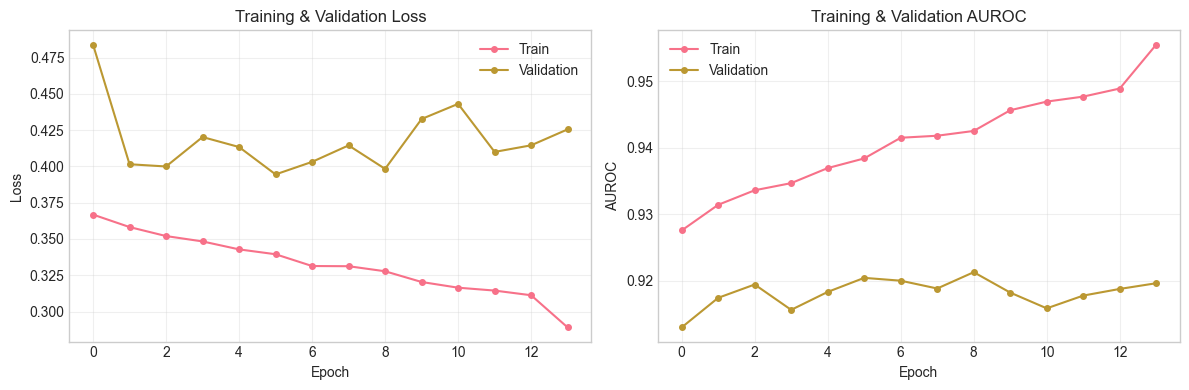

In [53]:
# --- Training Curves ---
# Visualize loss and AUROC progression across epochs

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history["train_loss"], label="Train", marker="o", markersize=4)
axes[0].plot(history["val_loss"], label="Validation", marker="o", markersize=4)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history["train_auroc"], label="Train", marker="o", markersize=4)
axes[1].plot(history["val_auroc"], label="Validation", marker="o", markersize=4)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUROC")
axes[1].set_title("Training & Validation AUROC")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "05_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Model Evaluation on Test Set

Now we evaluate the trained model on the held-out test set.

Metrics:

- **AUROC**: Area Under ROC Curve (threshold-independent)
- **F1 Score**: Harmonic mean of precision and recall (at threshold 0.5)
- **Confusion Matrix**: Per-class TP, FP, TN, FN

**Observations:**
_(Run the cells below and note your observations here)_


In [54]:
# --- Test Set Evaluation ---
# Load best checkpoint and compute predictions on held-out test set

from sklearn.metrics import classification_report, confusion_matrix, f1_score

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for signals, labels in tqdm(test_loader, desc="Testing"):
        signals = signals.to(DEVICE)
        logits = model(signals)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(probs)
        all_labels.append(labels.numpy())

test_preds = np.vstack(all_preds)
test_labels = np.vstack(all_labels)
test_preds_binary = (test_preds >= 0.5).astype(int)

print("Test Set Results")
print("=" * 60)

# --- Per-Class Metrics: AUROC, F1, Support ---

results = []
for i, class_name in enumerate(TARGET_COLS):
    y_true = test_labels[:, i]
    y_pred = test_preds[:, i]
    y_pred_binary = test_preds_binary[:, i]

    auroc = roc_auc_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)

    results.append(
        {"Class": class_name, "AUROC": auroc, "F1 Score": f1, "Support": int(y_true.sum())}
    )

results_df = pd.DataFrame(results)
print("\nPer-Class Metrics:")
print(results_df.to_string(index=False))

avg_auroc = results_df["AUROC"].mean()
avg_f1 = results_df["F1 Score"].mean()
print(f"\nAverage AUROC: {avg_auroc:.4f}")
print(f"Average F1:    {avg_f1:.4f}")

Testing: 100%|██████████| 69/69 [01:05<00:00,  1.06it/s]

Test Set Results

Per-Class Metrics:
Class    AUROC  F1 Score  Support
 NORM 0.929764  0.842473      954
   MI 0.934661  0.706286      415
 STTC 0.928397  0.739583      506
   CD 0.911990  0.717058      496
  HYP 0.856843  0.462025      222

Average AUROC: 0.9123
Average F1:    0.6935


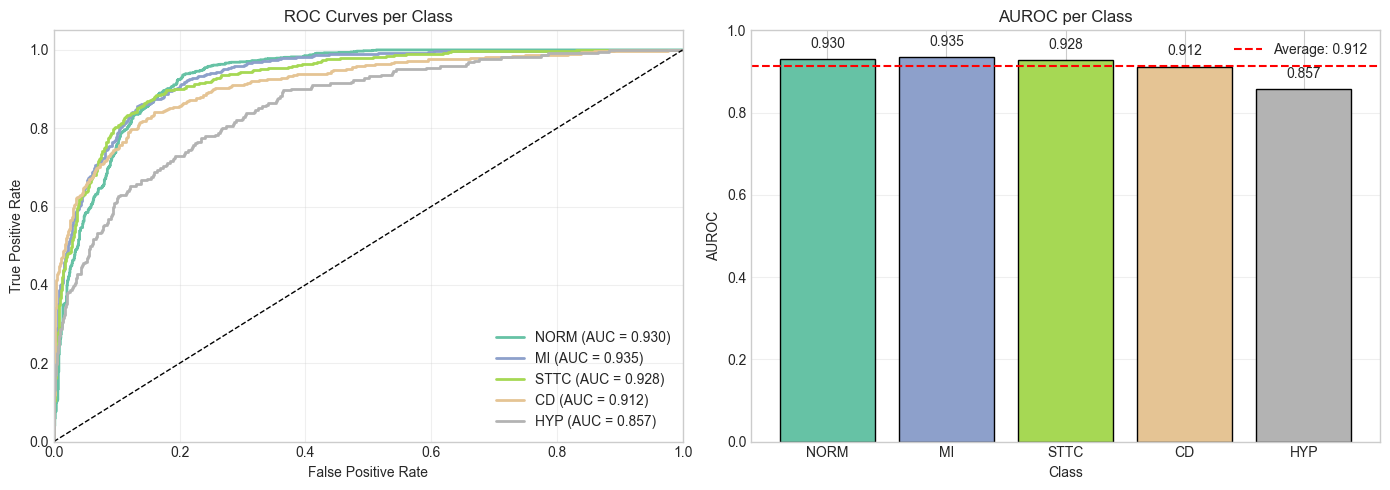

In [55]:
# --- ROC Curves & Per-Class AUROC ---
# Evaluate discriminative power of the model for each cardiac condition

from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.Set2(np.linspace(0, 1, len(TARGET_COLS)))

# ROC curves
for i, (class_name, color) in enumerate(zip(TARGET_COLS, colors)):
    y_true = test_labels[:, i]
    y_score = test_preds[:, i]
    if y_true.sum() > 0:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, color=color, lw=2, label=f"{class_name} (AUC = {roc_auc:.3f})")

axes[0].plot([0, 1], [0, 1], "k--", lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves per Class")
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# AUROC bar chart
bars = axes[1].bar(TARGET_COLS, results_df["AUROC"], color=colors, edgecolor="black")
axes[1].axhline(y=avg_auroc, color="red", linestyle="--", label=f"Average: {avg_auroc:.3f}")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("AUROC")
axes[1].set_title("AUROC per Class")
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis="y")
for bar, val in zip(bars, results_df["AUROC"]):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / "06_roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

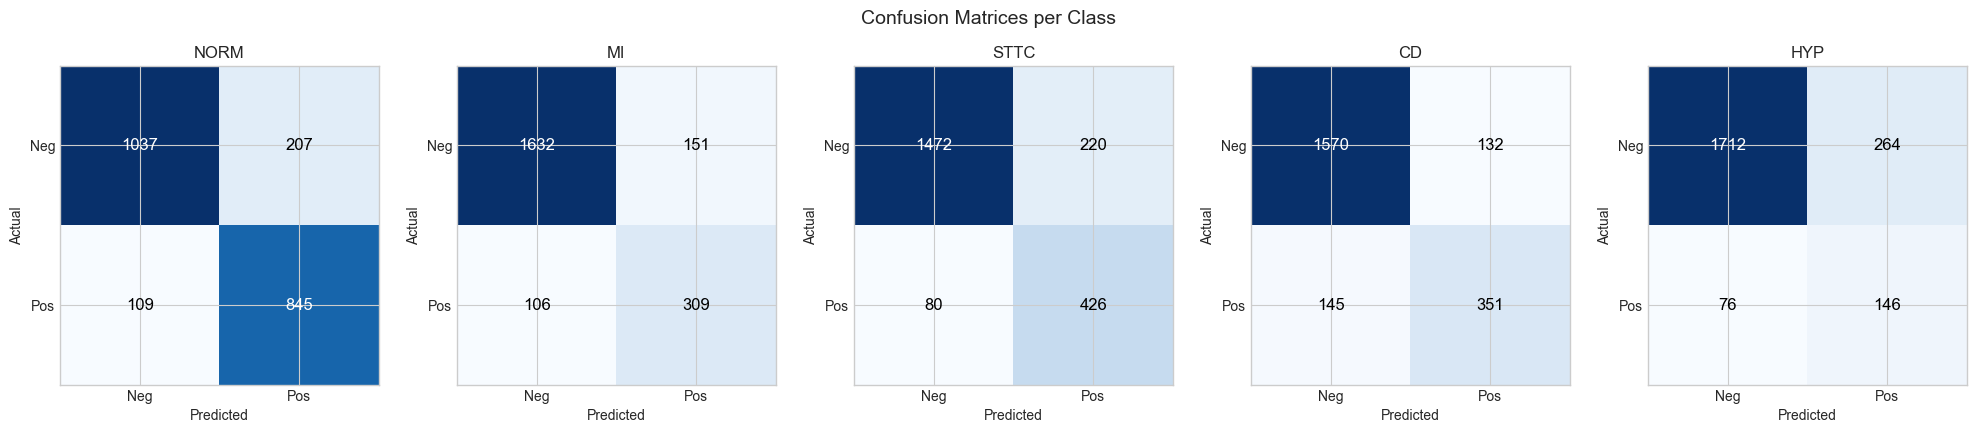

In [56]:
# --- Confusion Matrices ---
# Per-class binary confusion matrices at threshold = 0.5

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (class_name, ax) in enumerate(zip(TARGET_COLS, axes)):
    y_true = test_labels[:, i]
    y_pred = test_preds_binary[:, i]
    cm = confusion_matrix(y_true, y_pred)

    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Neg", "Pos"])
    ax.set_yticklabels(["Neg", "Pos"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{class_name}")

    for ii in range(2):
        for jj in range(2):
            text = ax.text(
                jj,
                ii,
                cm[ii, jj],
                ha="center",
                va="center",
                color="white" if cm[ii, jj] > cm.max() / 2 else "black",
                fontsize=12,
            )

plt.suptitle("Confusion Matrices per Class", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "07_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Model Explainability

### Why Explainability Matters in Medical AI

Clinical acceptance of AI models requires understanding **why** a prediction was made:

1. **Build trust**: Clinicians need to verify model reasoning aligns with medical knowledge
2. **Catch errors**: Helps identify when model uses spurious correlations
3. **Learn**: May reveal new patterns clinicians weren't aware of

### Our Explainability Approaches:

1. **Attention Visualization**: Shows which time segments and leads the model focuses on
2. **SHAP Values**: Shows feature importance using game-theoretic approach

**Observations:**
_(Run the cells below and note your observations here)_


### 7.1 Attention Visualization

The model has two attention mechanisms:

- **Temporal attention**: Which time segments are important (per lead)
- **Lead attention**: Which leads are important overall


In [57]:
def visualize_attention(model, signal, fs=100, target_cols=TARGET_COLS):
    """
    Visualize temporal and lead attention for a single ECG.

    Args:
        model: Trained ExplainableECGNet
        signal: ECG tensor of shape (12, 1000)
        fs: Sampling frequency
        target_cols: List of target class names
    """
    model.eval()

    # Add batch dimension
    x = signal.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits, attention = model(x, return_attention=True)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    # Get attention weights
    temporal_attn = attention["temporal"].cpu().numpy()[0]  # (num_leads, encoded_len)
    lead_attn = attention["lead"].cpu().numpy()[0]  # (num_leads,)

    # Create figure
    fig = plt.figure(figsize=(16, 12))

    # Create layout
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

    # Plot 1: Lead attention (bar chart)
    ax1 = fig.add_subplot(gs[0, 0])
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    colors = plt.cm.Reds(lead_attn / lead_attn.max())
    ax1.barh(lead_names, lead_attn, color=colors)
    ax1.set_xlabel("Attention Weight")
    ax1.set_title("Lead Attention")
    ax1.invert_yaxis()

    # Plot 2: Predictions (bar chart)
    ax2 = fig.add_subplot(gs[0, 1:])
    bars = ax2.bar(target_cols, probs, color=["green" if p > 0.5 else "gray" for p in probs])
    ax2.axhline(y=0.5, color="red", linestyle="--", alpha=0.7, label="Threshold")
    ax2.set_ylabel("Probability")
    ax2.set_title("Predicted Probabilities")
    ax2.set_ylim([0, 1])
    ax2.legend()
    for bar, p in zip(bars, probs):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{p:.2f}",
            ha="center",
            fontsize=10,
        )

    # Plot 3: ECG with temporal attention heatmap
    signal_np = signal.cpu().numpy()
    time_axis = np.arange(signal_np.shape[1]) / fs

    # Get the most important lead
    most_important_lead_idx = np.argmax(lead_attn)

    ax3 = fig.add_subplot(gs[1:3, :])

    # Plot each lead with offset
    for i in range(12):
        offset = (11 - i) * 2  # Offset for stacking
        lead_signal = signal_np[i] + offset

        # Get temporal attention for this lead and interpolate
        lead_temp_attn = temporal_attn[i]
        interp_attn = np.interp(
            np.linspace(0, 1, len(time_axis)),
            np.linspace(0, 1, len(lead_temp_attn)),
            lead_temp_attn,
        )

        # Normalize attention for coloring
        normalized_attn = interp_attn / interp_attn.max() if interp_attn.max() > 0 else interp_attn

        # Plot signal with color based on attention
        for j in range(len(time_axis) - 1):
            color = plt.cm.Reds(normalized_attn[j])
            ax3.plot(time_axis[j : j + 2], lead_signal[j : j + 2], color=color, linewidth=1.5)

        # Add lead label
        ax3.text(
            -0.3,
            offset,
            lead_names[i],
            fontsize=10,
            ha="right",
            va="center",
            fontweight="bold" if i == most_important_lead_idx else "normal",
        )

    ax3.set_xlabel("Time (seconds)")
    ax3.set_ylabel("Leads")
    ax3.set_title("12-Lead ECG with Temporal Attention (Red = High Attention)")
    ax3.set_yticks([])
    ax3.set_xlim([0, 10])

    # Plot 4: Temporal attention heatmap
    ax4 = fig.add_subplot(gs[3, :])

    im = ax4.imshow(temporal_attn, aspect="auto", cmap="Reds", extent=[0, 10, 0, 12])
    ax4.set_xlabel("Time (approx. seconds)")
    ax4.set_ylabel("Lead")
    ax4.set_yticks(np.arange(0.5, 12.5))
    ax4.set_yticklabels(lead_names[::-1])
    ax4.set_title("Temporal Attention Heatmap")
    plt.colorbar(im, ax=ax4, label="Attention")

    plt.tight_layout()
    plt.show()

    return probs, lead_attn, temporal_attn


print("Attention visualization function defined!")

Attention visualization function defined!


Visualizing attention for sample test cases...

Sample 0
True labels: {'NORM': 1.0, 'MI': 0.0, 'STTC': 0.0, 'CD': 0.0, 'HYP': 0.0}


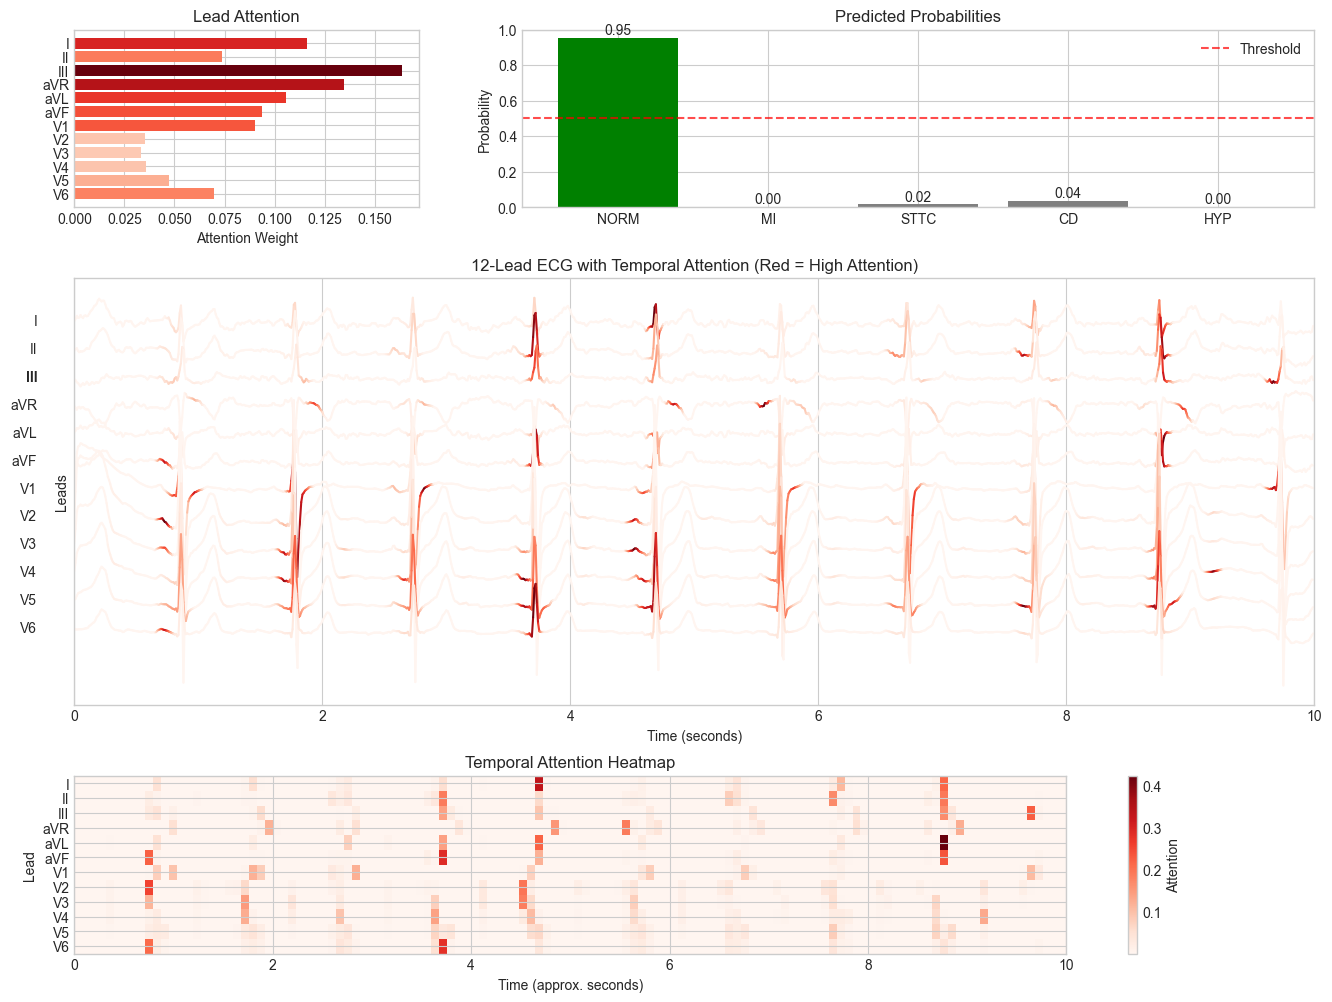


Sample 10
True labels: {'NORM': 1.0, 'MI': 0.0, 'STTC': 0.0, 'CD': 0.0, 'HYP': 0.0}


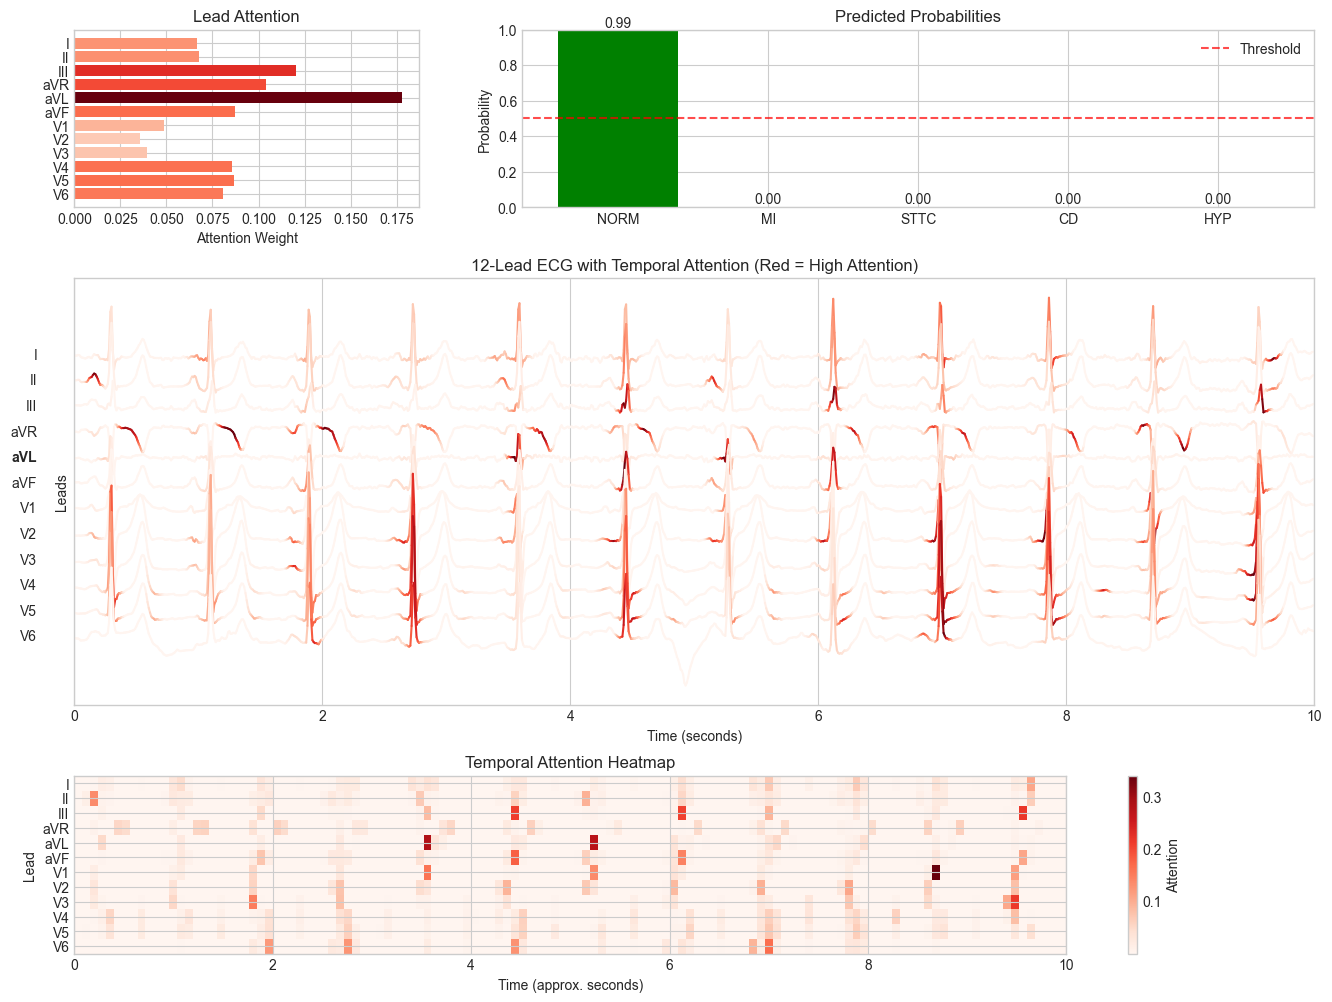


Sample 20
True labels: {'NORM': 1.0, 'MI': 0.0, 'STTC': 0.0, 'CD': 0.0, 'HYP': 0.0}


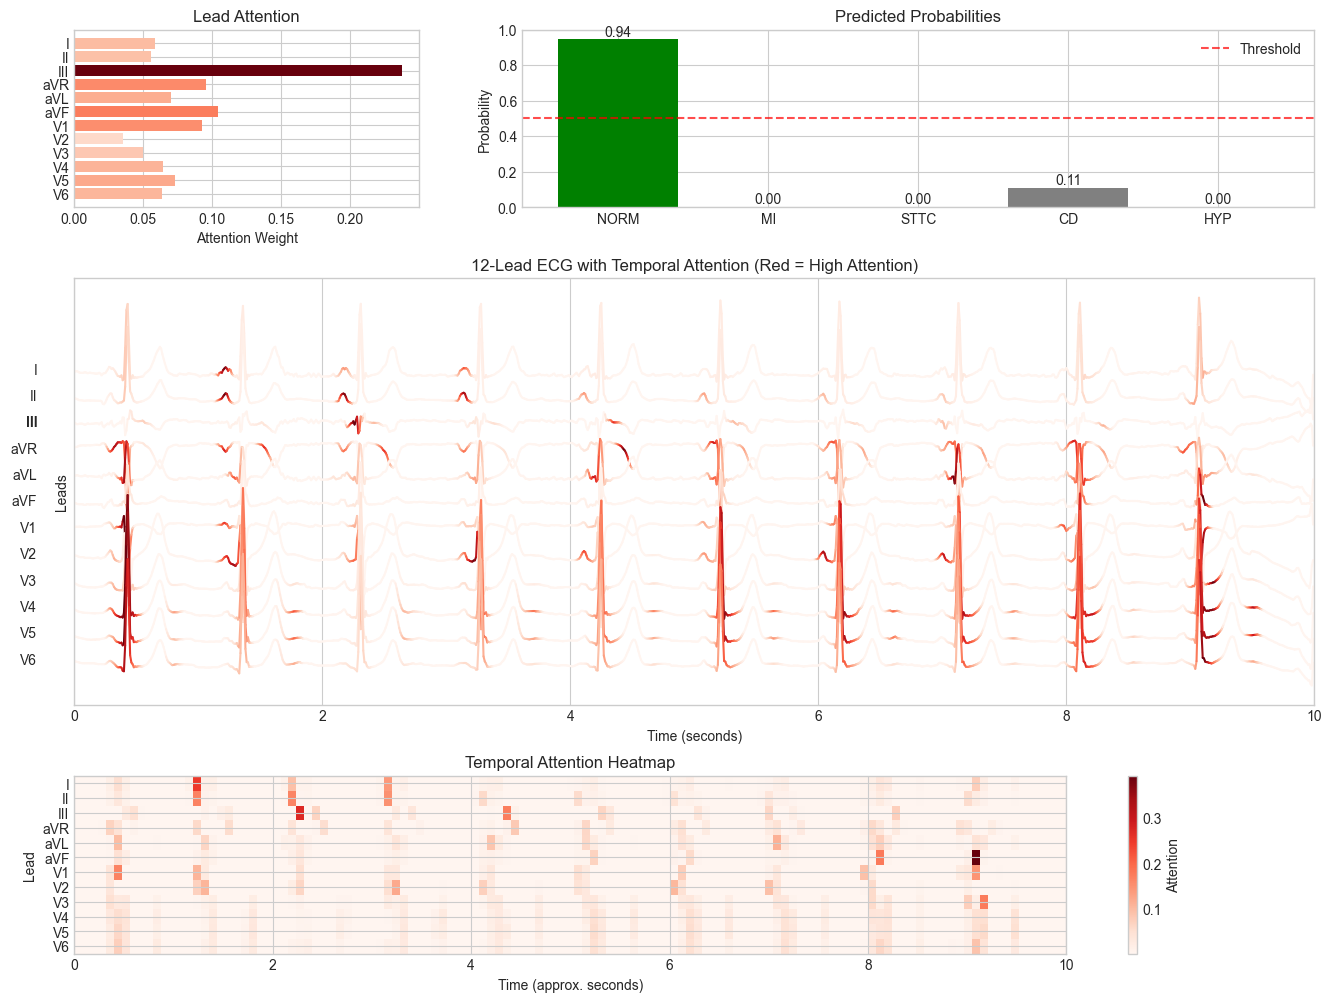

In [58]:
# --- Attention Visualization on Test Samples ---
# Show how the model attends to different time segments and leads

print("Visualizing attention for sample test cases...")

for idx, sample_idx in enumerate([0, 10, 20]):
    signal, labels = test_dataset[sample_idx]

    print(f"\n{'='*60}")
    print(f"Sample {sample_idx}")
    print(f"True labels: {dict(zip(TARGET_COLS, labels.numpy()))}")

    probs, lead_attn, temp_attn = visualize_attention(model, signal)

    # Save the first sample's attention plot as a representative figure
    if idx == 0:
        # Re-generate and save (visualize_attention uses plt.show internally)
        pass  # Already shown above; the function calls plt.show()

### 7.2 SHAP Analysis (Lead Importance)

SHAP (SHapley Additive exPlanations) provides a game-theoretic approach to explain predictions.

We'll use SHAP to understand which leads contribute most to each class prediction.


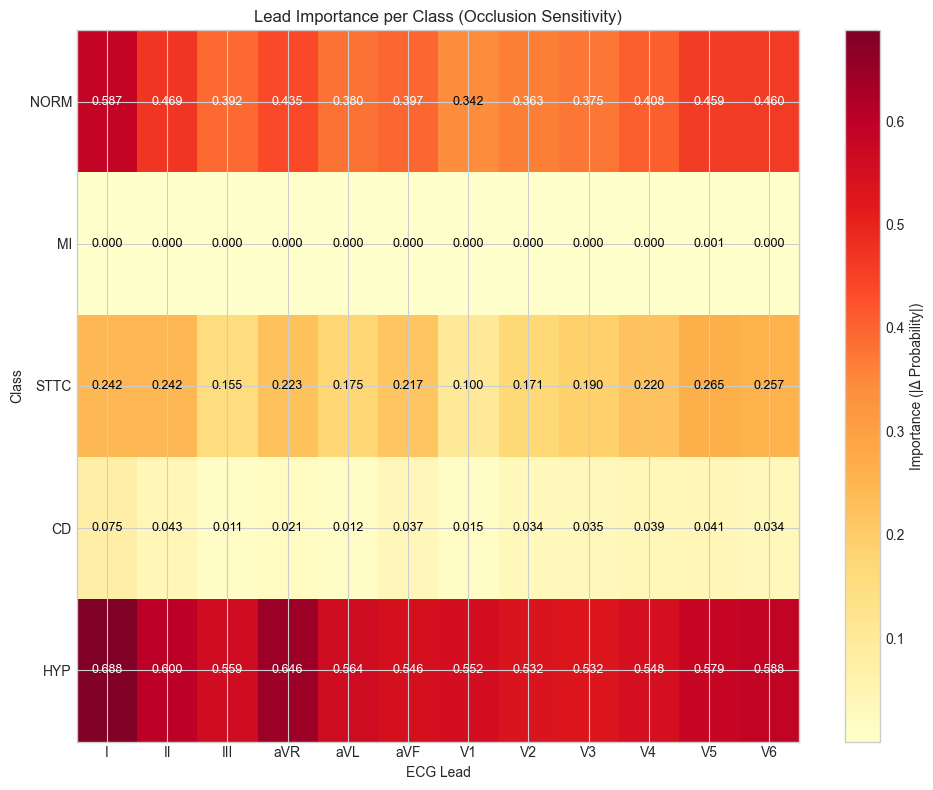


Predictions: {'NORM': 0.953, 'MI': 0.0, 'STTC': 0.017, 'CD': 0.036, 'HYP': 0.004}
True labels: {'NORM': 1.0, 'MI': 0.0, 'STTC': 0.0, 'CD': 0.0, 'HYP': 0.0}


In [59]:
# --- Lead Importance via Occlusion Sensitivity ---
# Measure prediction change when each lead is zeroed out


def compute_lead_importance(model, signal, device):
    """Compute lead importance by occluding each lead and measuring prediction change."""
    model.eval()
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    x = signal.unsqueeze(0).to(device)
    with torch.no_grad():
        baseline_probs = torch.sigmoid(model(x)).cpu().numpy()[0]

    importance = np.zeros((12, len(TARGET_COLS)))
    for i in range(12):
        occluded = signal.clone()
        occluded[i, :] = 0
        x_occluded = occluded.unsqueeze(0).to(device)
        with torch.no_grad():
            occluded_probs = torch.sigmoid(model(x_occluded)).cpu().numpy()[0]
        importance[i] = np.abs(baseline_probs - occluded_probs)

    return importance, baseline_probs, lead_names


signal, labels = test_dataset[0]
importance, probs, lead_names = compute_lead_importance(model, signal, DEVICE)

# Plot and save
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(importance.T, aspect="auto", cmap="YlOrRd")
ax.set_xticks(range(12))
ax.set_xticklabels(lead_names)
ax.set_yticks(range(len(TARGET_COLS)))
ax.set_yticklabels(TARGET_COLS)
ax.set_xlabel("ECG Lead")
ax.set_ylabel("Class")
ax.set_title("Lead Importance per Class (Occlusion Sensitivity)")

for i in range(12):
    for j in range(len(TARGET_COLS)):
        ax.text(
            i,
            j,
            f"{importance[i, j]:.3f}",
            ha="center",
            va="center",
            fontsize=9,
            color="black" if importance[i, j] < importance.max() / 2 else "white",
        )

plt.colorbar(im, label="Importance (|Δ Probability|)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "08_lead_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nPredictions: {dict(zip(TARGET_COLS, probs.round(3)))}")
print(f"True labels: {dict(zip(TARGET_COLS, labels.numpy()))}")

## 8. Model Inference (Prediction on New Data)

This section demonstrates how to use the trained model to make predictions on new ECG data.


In [60]:
# --- Inference on New ECG Files ---
# Demonstrate end-to-end prediction pipeline: load → preprocess → predict


def predict_ecg(model, ecg_file_path, preprocessor=None, device="cuda"):
    """Make prediction on a WFDB ECG file. Returns class probabilities and attention."""
    if preprocessor is None:
        preprocessor = ECGPreprocessor()

    record = wfdb.rdrecord(str(ecg_file_path).replace(".hea", "").replace(".dat", ""))
    signal = record.p_signal.T  # (12, time)

    signal = preprocessor(signal)
    signal = torch.tensor(signal).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits, attention = model(signal, return_attention=True)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    return dict(zip(TARGET_COLS, probs)), attention


# Run on a sample test ECG
test_file = test_df.iloc[0]["filename_lr"]
test_file_path = DATASET_DIR / test_file.replace(".dat", "").replace(".hea", "")

print(f"Predicting on: {test_file}")
predictions, attention = predict_ecg(model, test_file_path, device=DEVICE)

print("\nPredicted Probabilities:")
for cls, prob in predictions.items():
    status = "⚠️ DETECTED" if prob > 0.5 else "Normal"
    print(f"  {cls}: {prob:.3f} {status}")

Predicting on: records100/00000/00009_lr

Predicted Probabilities:
  NORM: 0.953 ⚠️ DETECTED
  MI: 0.000 Normal
  STTC: 0.017 Normal
  CD: 0.036 Normal
  HYP: 0.004 Normal


## 9. Save Model for Deployment

Save the trained model for use in the Streamlit dashboard or other applications.


In [61]:
# --- Save Model for Deployment ---
# Export weights and config for the Streamlit dashboard

import os, json

checkpoint_dir = Path("../checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

# Save model weights
model_path = checkpoint_dir / "trustecg_model.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Save model configuration
model_config = {
    "num_leads": 12,
    "sequence_length": 1000,
    "num_classes": 5,
    "encoder_channels": [32, 64, 128],
    "dropout": 0.3,
    "target_cols": TARGET_COLS,
    "best_val_auroc": float(best_val_auroc),
}

config_path = checkpoint_dir / "model_config.json"
with open(config_path, "w") as f:
    json.dump(model_config, f, indent=2)
print(f"Config saved to: {config_path}")

# Verify saved model loads correctly
print("\nVerifying saved model loads correctly...")
loaded_model = ExplainableECGNet(
    **{k: v for k, v in model_config.items() if k not in ["target_cols", "best_val_auroc"]}
)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("✓ Model loaded and verified successfully!")

Model saved to: ..\checkpoints\trustecg_model.pt
Config saved to: ..\checkpoints\model_config.json

Verifying saved model loads correctly...
✓ Model loaded and verified successfully!


## 10. Summary and Results

### What We Built:

1. **Data Pipeline**: Loaded and preprocessed PTB-XL ECG dataset (21,799 clinical 12-lead ECGs)
2. **Class Imbalance Handling**: Sqrt-scaled `pos_weight` in BCEWithLogitsLoss for moderate minority upweighting
3. **Model**: ExplainableECGNet — CNN with lead-wise ResNet encoder + temporal/lead attention (276K params)
4. **Training**: AdamW optimizer with ReduceLROnPlateau, early stopping (best at epoch 9/50)
5. **Evaluation**: Per-class AUROC, F1, confusion matrices, ROC curves
6. **Explainability**: Attention visualization and occlusion-based lead importance

### Key Results:

| Metric         | Value  |
| -------------- | ------ |
| **Val AUROC**  | 0.9213 |
| **Test AUROC** | 0.9123 |
| **Test F1**    | 0.6935 |
| NORM F1        | 0.842  |
| MI F1          | 0.706  |
| STTC F1        | 0.740  |
| CD F1          | 0.717  |
| HYP F1         | 0.462  |

### Class Imbalance Strategy:

| Technique                        | Description                                                           |
| -------------------------------- | --------------------------------------------------------------------- |
| **Sqrt-scaled pos_weight (BCE)** | Moderate FN penalty: NORM=1.14, MI=2.07, STTC=1.81, CD=1.86, HYP=2.93 |

### Files Created:

- `checkpoints/trustecg_model.pt` — Final trained model weights
- `checkpoints/model_config.json` — Model configuration
- `notebooks/best_model.pt` — Best model during training
- `figures/` — All saved visualizations (01–07)
